In [1]:
from __future__ import annotations
from typing import Optional, Tuple
import pandas as pd 
from copy import deepcopy
from scipy.stats.contingency import odds_ratio
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import itertools

warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.float_format = "{:,.2f}".format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

**Loading**

In [2]:
# load to dataframe
INFILE = '/home/grace/work/SEER/data/SEERPLUS_2010_2020.clean.tsv'
master = pd.read_csv(INFILE, header=0, sep='\t', na_values='.')

In [ ]:
# NOTE: donor 1037 is annoying. 
master[master['patient_id']==1037]

In [3]:
# basic formatting
from util_funcs import do_basic_formatting
from util_funcs import do_basic_filtering
from util_funcs import remove_identical_primary_secondary_cases

print('\nBasic filtering')
df = do_basic_filtering(master)
df = remove_identical_primary_secondary_cases(df)

HISTTYPES_PATH = '/home/grace/work/SEER/data/histology/histcodes.tsv'
print('\nBasic formatting')
df = do_basic_formatting(df, HISTTYPES_PATH)

df.head()


Basic filtering
Removing records not in range (2010, 2020)
- removed 371509 records
Selecting records with MALIGNANT behavior
- removed 632160 records
Handling patients with multiple records of same cancer_type
- removed 82397 records
Removing records where brain_met value is missing
- removed 695869 records

Final records: 3822648, patients: 3620282
Removing MET records where primary tissue is identical to secondary tissue
- removed 67488 records

Basic formatting
Missing 0 codes.
Formatting cancer subtypes
TNG, Grade standardisation


,patient_id,patient_death_year,diagnosis_year,followup_year,diagnosis_agebin,cancer_type,cancer_group,primary_type,primary_group,t_stage_ajcc,n_stage_ajcc,g_stage_ajcc,t_stage_src,n_stage_src,g_stage_src,grade,grade_src,regional_nodes,regional_nodes_examined,regional_nodes_positive,behavior,num_malignant_tumors,num_benign_tumors,psa,breast_subtype,hist_type,hist_cateogry,brain_met,bone_met,lung_met,liver_met,distant_ln,any_met,hist_type_descr,TSTAGE_STD,NSTAGE_STD,GSTAGE_STD,GRADE_STD
4,139,"2,011.00",2010,2011,70-74 years,Breast,Breast,Breast,Breast,T3,N0,IIB,NaN,NaN,NaN,G3,NaN,NEG,3.00,0.00,MALIGNANT,3,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,NaN,NO,Infiltrating duct carcinoma [+ others],T3,N0,II,G3
5,142,NaN,2018,2020,70-74 years,Breast,Breast,Breast,Breast,T2,N0,IIA,NaN,NaN,NaN,G3,P,NEG,3.00,0.00,MALIGNANT,2,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,False,NO,Infiltrating duct carcinoma [+ others],T2,N0,II,G3
6,194,NaN,2016,2020,55-59 years,Ovary,Ovary,Ovary,Ovary,T1c,N0,IC,P,P,NaN,G2,NaN,NEG,10.00,0.00,MALIGNANT,2,0,NaN,NaN,8441,"cystic, mucinous and serous neoplasms",NO,NO,NO,NO,False,NO,Serous carcinoma [+ others],T1,N0,I,G2
7,220,NaN,2011,2020,70-74 years,Prostate,Prostate,Prostate,Prostate,T1c,N0,II,NaN,NaN,NaN,G2,NaN,NaN,0.00,NaN,MALIGNANT,2,0,6.60,NaN,8140,adenomas and adenocarcinomas,NO,NO,NO,NO,NaN,NO,Adenoma [+ others],T1,N0,II,G2
8,265,"2,016.00",2011,2016,65-69 years,Prostate,Prostate,Prostate,Prostate,T2c,N0,II,NaN,NaN,NaN,G3,NaN,NaN,0.00,NaN,MALIGNANT,2,0,7.70,NaN,8140,adenomas and adenocarcinomas,NO,NO,NO,NO,NaN,NO,Adenoma [+ others],T2,N0,II,G3


## T-stage

Takeaways
- The general trend is increasing BM risk with increasing T-stage
    - cancer_type / cancer_group / hist_type_descr / hist_category
- The increase in risk is different per cancer type.
    - Flat: Mesothelioma, Pancreas, stomach
    - Gentle: Lung, Liver, intradepatic bile duct, Soft Tissue including Heart
    - Aggressive: Prostate, Thyroid, Skin
- Some have pronounced difference between T0 & T1/2/3
    - Larynx, Kidney and Renal Pelvis, Urinary bladder



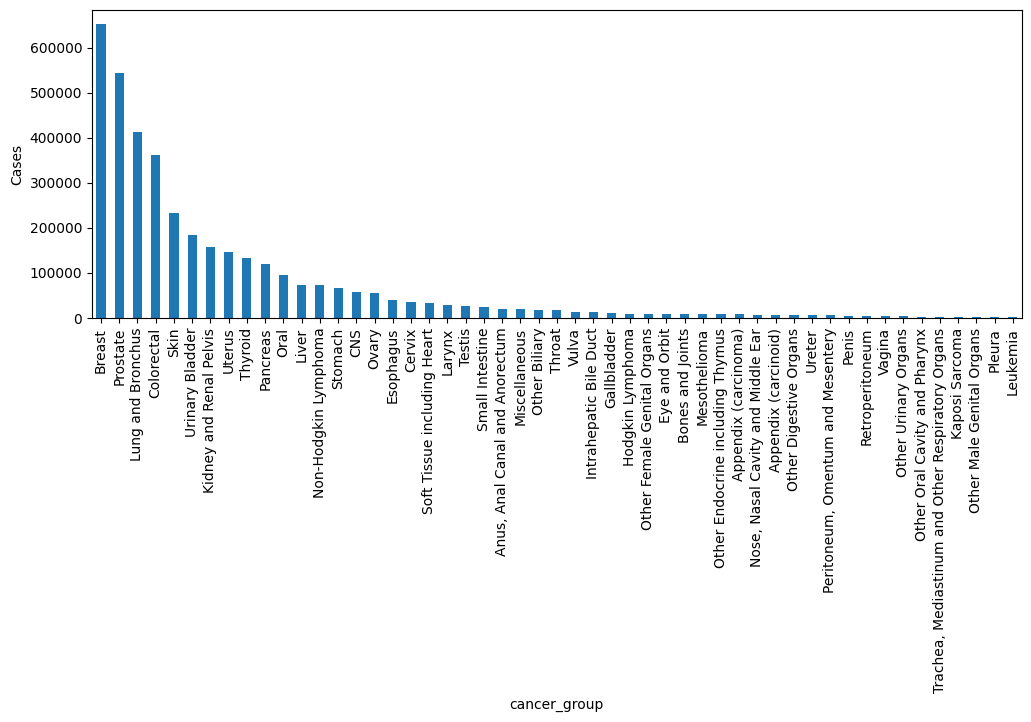

In [4]:
# sns.histplot(data=df, x='cancer_group', hue='cancer_group')
fig, ax = plt.subplots(figsize=(12, 4))
df['cancer_group'].value_counts().plot(kind="bar")
ax.set_ylabel('Cases')
plt.show()

In [6]:
df['TSTAGE_STD'].value_counts(dropna=False)

TSTAGE_STD
T1     1413803
T2      837863
NaN     658834
T3      543735
T4      300925
Name: count, dtype: int64

39/41 subsets calculated
Removed 13/41 groups
  derived_feature      NO  YES  records  prevalence (%)  relrisk OR_STAT OR_CI_LOW OR_CI_HIGH derived_group
0               1  368171  269   368440            0.07     0.02   -1.51     -1.64      -1.38        Breast
1               2  189943  609   190552            0.32     0.07   -0.03     -0.12       0.06        Breast
2               3   38620  333    38953            0.85     0.19    0.96      0.84       1.08        Breast
3               4   25802  844    26646            3.17     0.72    2.29      2.21       2.37        Breast
4               1   15264   21    15285            0.14     0.27   -0.15     -0.63       0.33         Ovary
39/41 subsets calculated
Removed 9/41 groups
  derived_feature      NO   YES  records  prevalence (%)  relrisk OR_STAT OR_CI_LOW OR_CI_HIGH derived_group
0               1  365937  2503   368440            0.68     0.02   -1.53     -1.57      -1.49        Breast
1               2  184028  6524   190552   

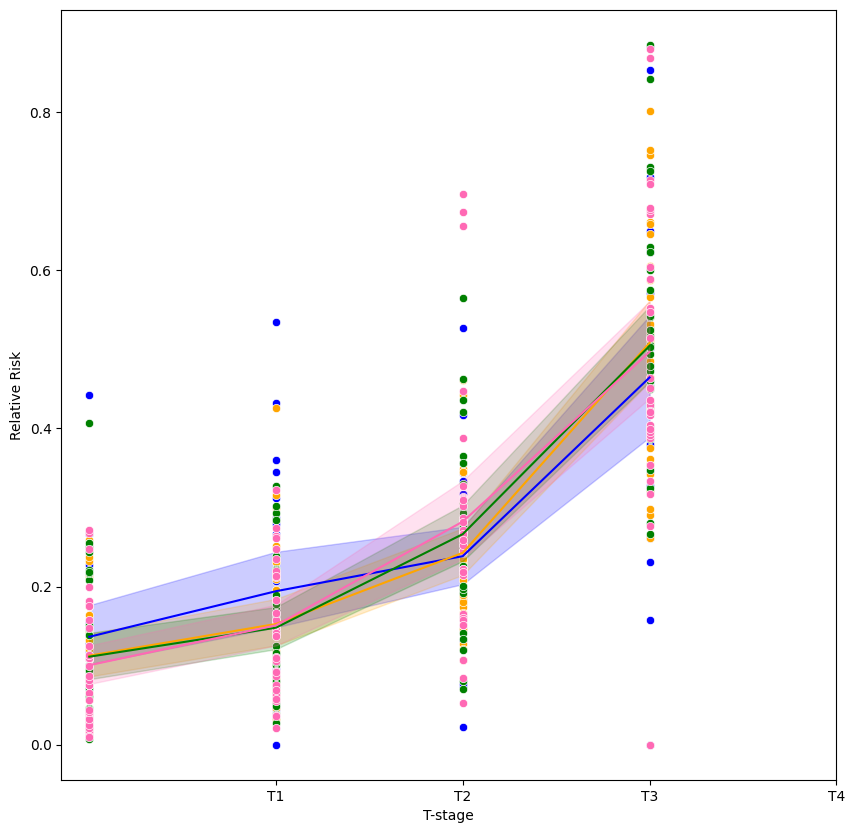

In [12]:
from util_classes import Settings
from util_funcs import calculate_stats_grouped

s = Settings()

temp = df.dropna(subset=['TSTAGE_STD'])
temp['tstage_int'] = temp['TSTAGE_STD'].map({'T1': 1, 'T2': 2, 'T3': 3, 'T4': 4})
temp['tstage_int'] = temp['tstage_int'].apply(int)

GROUPS = ['cancer_group']
FEATURES = ['tstage_int']
MET_FIELDS = ['brain_met', 'bone_met', 'lung_met', 'liver_met']
MET_COLORS = ['blue', 'orange', 'green', 'hotpink']

fix, ax = plt.subplots(figsize=(10, 10))
for met, color in zip(MET_FIELDS, MET_COLORS):
    maintable = calculate_stats_grouped(
        groups=GROUPS, 
        features=FEATURES, 
        response_field=met,
        s=s,
        df=temp
    )
    # TODO ensure same cancer_groups shared across mets
    print(maintable.head())
    sns.lineplot(data=maintable, x='derived_feature', y='relrisk', color=color, ax=ax) 
    sns.scatterplot(data=maintable, x='derived_feature', y='relrisk', color=color, ax=ax) 

ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['T1', 'T2', 'T3', 'T4'])
ax.set_xlabel('')
ax.set_ylabel('')

ax.set_xlabel('T-stage')
ax.set_ylabel('Relative Risk')
plt.show()


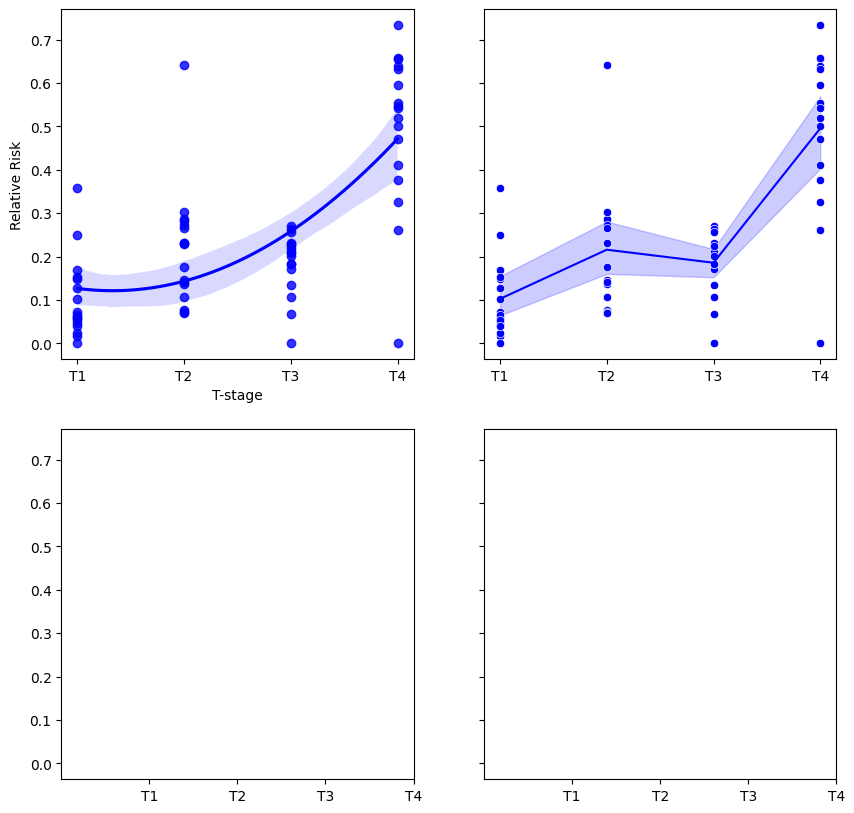

In [73]:
# print(maintable.head())
# print(maintable['derived_feature'].value_counts(dropna=False))
# print(maintable['norm'].value_counts(dropna=False))
cgroup_gentle = set([
    'Mesothelioma',
    'Pancreas',
    'Esophagus',
    'Stomach',
    'Colorectal',
    'Other Biliary',
    'Cervix',
    'Uterus',
    'Throat',
    'Nose, Nasal Cavity and Middle Ear',
    'Soft Tissue including Heart',
    'Kidney and Renal Pelvis',
    'Urinary Bladder',
    'Liver',
    'Larynx',
    'Intrahepatic Bile Duct',
    'Lung and Bronchus',
    'Small Intestine',
])

cgroup_aggressive = set([
    'Eye and Orbit', 
    'Other Endocrine including Thymus'
    'Gallbladder', 
    'Appendix',
    'Breast', 
    'Ureter',
    'Oral',
    'Vulva'
    'Skin',
    'Testis',
    'Prostate',
    'Thyroid',
])

maintable['tstage_int'] = maintable['derived_feature'].map({'T1': 1, 'T2': 2, 'T3': 3, 'T4': 4})
maintable['tstage_int'] = maintable['tstage_int'].apply(int)
maintable['norm'] = maintable['norm'].apply(float)

fix, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharey=True)
ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]

# top left
sns.regplot(data=maintable, x='tstage_int', y='norm', color='b', order=2, ax=ax1) 

# top right
sns.lineplot(data=maintable, x='tstage_int', y='norm', color='b', ax=ax2) 
sns.scatterplot(data=maintable, x='tstage_int', y='norm', color='b', ax=ax2) 

# aggr_table = maintable[maintable['derived_group'].isin(aggressive)]
# gent_table = maintable[maintable['derived_group'].isin(gentle)]

# # bottom left
# sns.regplot(data=aggr_table, x='tstage_int', y='norm', color='green', order=2, ax=ax3) 
# sns.regplot(data=gent_table, x='tstage_int', y='norm', color='hotpink', order=2, ax=ax3) 

# # bottom right
# sns.lineplot(data=aggr_table, x='tstage_int', y='norm', color='green', ax=ax4) 
# sns.lineplot(data=gent_table, x='tstage_int', y='norm', color='hotpink', ax=ax4) 
# sns.scatterplot(data=aggr_table, x='tstage_int', y='norm', color='green', ax=ax4) 
# sns.scatterplot(data=gent_table, x='tstage_int', y='norm', color='hotpink', ax=ax4) 

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([1, 2, 3, 4])
    ax.set_xticklabels(['T1', 'T2', 'T3', 'T4'])
    ax.set_xlabel('')
    ax.set_ylabel('')

ax1.set_xlabel('T-stage')
ax1.set_ylabel('Relative Risk')
plt.show()


## GRADE

In [66]:
import os 
from util_classes import Settings
from util_funcs import normalize_field_pergroup
from util_funcs import calculate_bm_prevalence_grouped
s = Settings()

GROUPS = ['cancer_type']
FEATURES = ['GRADE_STD']
NORM = 'brain_met'

# calculate prevalence per group
maintable = calculate_bm_prevalence_grouped(
    groups=GROUPS, 
    features=FEATURES, 
    response_field=NORM,
    s=s,
    df=df
)

# normalise prevalence 
maintable = normalize_field_pergroup(
    groups=s.COMPOUND_GROUP,
    target_field=s.RATE_FIELD, 
    norm_field=s.NORM_FIELD,
    norm_meth=s.NORM_METH,
    df=maintable,
)


64/70 subsets calculated
Removed 32/70 groups:
-Myeloma
-NHL - Extranodal
-Ureter
-Hypopharynx
-Chronic Lymphocytic Leukemia
-Splenic Flexure
-Other Urinary Organs
-Acute Myeloid Leukemia
-Vulva
-Other Lymphocytic Leukemia
-Miscellaneous
-Larynx
-Acute Lymphocytic Leukemia
-Eye and Orbit
-Oropharynx
-Floor of Mouth
-Other Female Genital Organs
-Other Non-Epithelial Skin
-Appendix (carcinoma)
-Peritoneum, Omentum and Mesentery
-Lip
-Retroperitoneum
-Vagina
-Other Endocrine including Thymus
-Aleukemic, Subleukemic and NOS
-Appendix (carcinoid)
-Corpus Uteri (sarcoma)
-Penis
-Cranial Nerves Other Nervous System
-Melanoma of the Skin
-Chronic Myeloid Leukemia
-Uterus, NOS



twolevel:
- Salivary Gland
- Small Intestine
- Corpus Uteri (carcinoma)
- Rectum
- Tongue
- Gum and Other Mouth
- Prostate
- Lung and Bronchus
- Cervix Uteri
- Soft Tissue including Heart
- Liver
- Pancreas
- Descending Colon
- Rectosigmoid Junction
- Hepatic Flexure
- Nose, Nasal Cavity and Middle Ear
- Large Intestine, NOS
- Other Biliary
- Brain
- Urinary Bladder
- Transverse Colon
- Intrahepatic Bile Duct
- Ascending Colon
- Cecum
- Ovary
- Nasopharynx
- Sigmoid Colon
- Tonsil
- Kidney and Renal Pelvis
- Gallbladder
- Anus, Anal Canal and Anorectum
- Bones and Joints


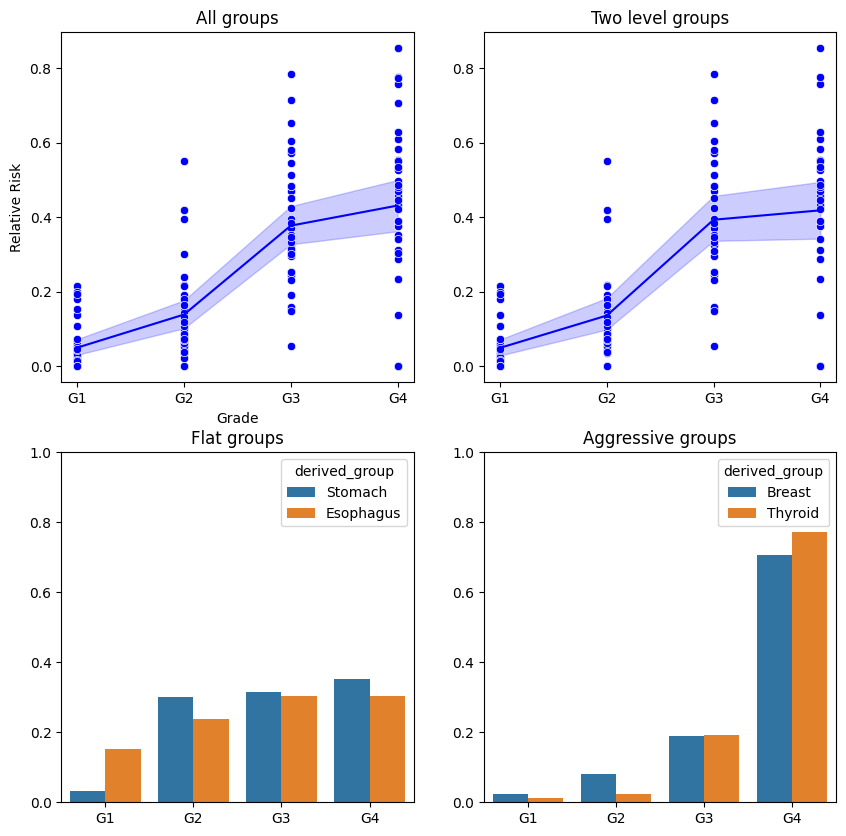

In [67]:

FEAT = 'gstage_int'
NORM = 'norm'
maintable[FEAT] = maintable['derived_feature'].map({'G1': 1, 'G2': 2, 'G3': 3, 'G4': 4})
maintable = maintable.dropna(subset=[FEAT])
maintable[FEAT] = maintable[FEAT].apply(int)
maintable[NORM] = maintable[NORM].apply(float)
 
flat = set([
    'Esophagus',
    'Stomach',
])

aggressive = set([
    'Oral',
    'Breast',
    'Thyroid',
])

twolevel = set([
    x for x in maintable['derived_group'].unique() 
    if x not in flat and x not in aggressive
])

print('\ntwolevel:')
for x in twolevel:
    print(f'- {x}')

twolevel_table = maintable[maintable['derived_group'].isin(twolevel)]
aggr_table = maintable[maintable['derived_group'].isin(aggressive)]
flat_table = maintable[maintable['derived_group'].isin(flat)]

fix, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax1 = axes[0, 0]
ax2 = axes[0, 1]
ax3 = axes[1, 0]
ax4 = axes[1, 1]

# top left
sns.lineplot(data=maintable, x=FEAT, y=NORM, color='b', ax=ax1) 
sns.scatterplot(data=maintable, x=FEAT, y=NORM, color='b', ax=ax1) 

# top right
sns.lineplot(data=twolevel_table, x=FEAT, y=NORM, color='b', ax=ax2) 
sns.scatterplot(data=twolevel_table, x=FEAT, y=NORM, color='b', ax=ax2) 

# bottom left
sns.barplot(data=flat_table, x=FEAT, y=NORM, hue='derived_group', ax=ax3, errorbar=None)

# bottom right
sns.barplot(data=aggr_table, x=FEAT, y=NORM, hue='derived_group', ax=ax4, errorbar=None)

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels(['G1', 'G2', 'G3', 'G4'])
for ax in [ax1, ax2]:
    ax.set_xticks([1, 2, 3, 4])
for ax in [ax3, ax4]:
    ax.set_xticks([0, 1, 2, 3])

ax1.set_xlabel('Grade')
ax1.set_ylabel('Relative Risk')
ax1.set_title('All groups')
ax2.set_title('Two level groups')
ax3.set_title('Flat groups')
ax4.set_title('Aggressive groups')
ax3.set_ylim(0, 1)
ax4.set_ylim(0, 1)
plt.show()


## N-stage

In [61]:
from util_maps import CGROUPS_NSTAGES_N0N1
from util_maps import CGROUPS_NSTAGES_N0N1N2
from util_maps import CGROUPS_NSTAGES_N0N1N2N3
from util_classes import Settings
from util_funcs import normalize_field_pergroup
from util_funcs import calculate_bm_prevalence_grouped
s = Settings()

print(df.shape)
nstage_df = df[~((df['cancer_group']=='Pancreas') & (df['NSTAGE_STD']=='N2'))]
nstage_df = nstage_df[~((nstage_df['cancer_group']=='Other Biliary') & (nstage_df['NSTAGE_STD']=='N2'))]
nstage_df = nstage_df[~((nstage_df['cancer_group']=='Appendix (carcinoid)') & (nstage_df['NSTAGE_STD']=='N2'))]
nstage_df = nstage_df[~((nstage_df['cancer_group']=='Kidney and Renal Pelvis') & (nstage_df['NSTAGE_STD']=='N3'))]
print(nstage_df.shape)


(4518561, 35)
(4516607, 35)


**N0,N1 tissues**

In [83]:
GROUPS = ['cancer_group']
FEATURES = ['NSTAGE_STD']
NORM = 'brain_met'
MIN_RECORDS = 1000

In [84]:

# subset cancer types
temp = nstage_df[nstage_df['cancer_group'].isin(CGROUPS_NSTAGES_N0N1)]

# calculate prevalence per group
maintable = calculate_bm_prevalence_grouped(
    groups=GROUPS, 
    features=FEATURES, 
    response_field=NORM,
    min_records=MIN_RECORDS,
    s=s,
    df=temp
)
# normalise prevalence 
maintable = normalize_field_pergroup(
    groups=s.COMPOUND_GROUP,
    target_field=s.RATE_FIELD, 
    norm_field=s.NORM_FIELD,
    norm_meth=s.NORM_METH,
    df=maintable,
)

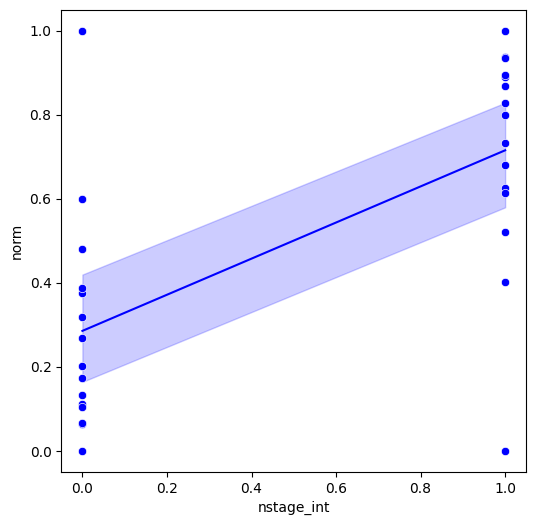

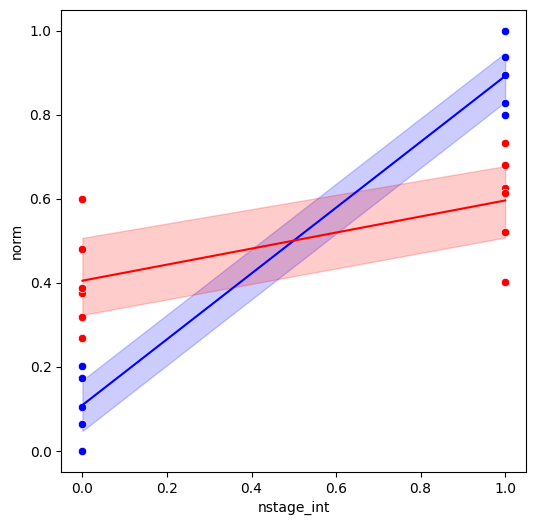

In [86]:
N0N1_AGGR = [
    'Other Female Genital Organs',
    'Soft Tissue including Heart',
    'Thyroid',
    'Prostate',
    'Cervix',
]
N0N1_GENTLE = [
    'Pancreas',
    'Vagina',
    'Liver',
    'Ovary',
    'Intrahepatic Bile Duct',
    'Other Biliary',
]

maintable['nstage_int'] = maintable['derived_feature'].map({'N0': 0, 'N1': 1})
maintable['nstage_int'] = maintable['nstage_int'].apply(int)
maintable['norm'] = maintable['norm'].apply(float)
aggr_table = maintable[maintable['derived_group'].isin(N0N1_AGGR)]
gent_table = maintable[maintable['derived_group'].isin(N0N1_GENTLE)]

fix, ax = plt.subplots(figsize=(6, 6))
sns.lineplot(data=maintable, x='nstage_int', y='norm', color='b') 
sns.scatterplot(data=maintable, x='nstage_int', y='norm', color='b') 
plt.show()

fix, ax = plt.subplots(figsize=(6, 6))
sns.lineplot(data=aggr_table, x='nstage_int', y='norm', color='b') 
sns.lineplot(data=gent_table, x='nstage_int', y='norm', color='r') 
sns.scatterplot(data=aggr_table, x='nstage_int', y='norm', color='b') 
sns.scatterplot(data=gent_table, x='nstage_int', y='norm', color='r') 
plt.show()


**N0,N1,N2 tissues**

In [92]:

# subset cancer types
temp = nstage_df[nstage_df['cancer_group'].isin(CGROUPS_NSTAGES_N0N1N2)]

# calculate prevalence per group
maintable = calculate_bm_prevalence_grouped(
    groups=GROUPS, 
    features=FEATURES, 
    response_field=NORM,
    min_records=MIN_RECORDS,
    s=s,
    df=temp
)
# normalise prevalence 
maintable = normalize_field_pergroup(
    groups=s.COMPOUND_GROUP,
    target_field=s.RATE_FIELD, 
    norm_field=s.NORM_FIELD,
    norm_meth=s.NORM_METH,
    df=maintable,
)

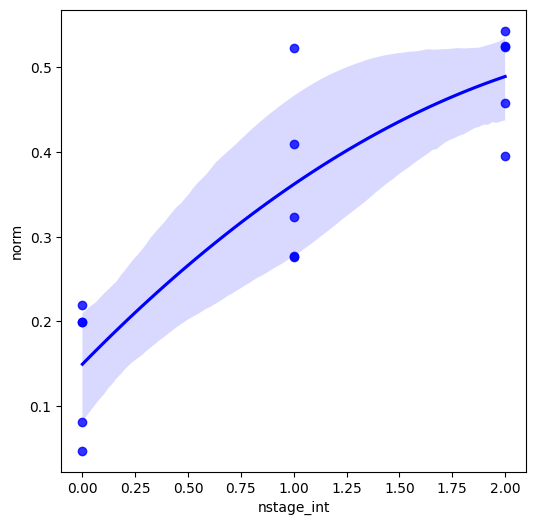

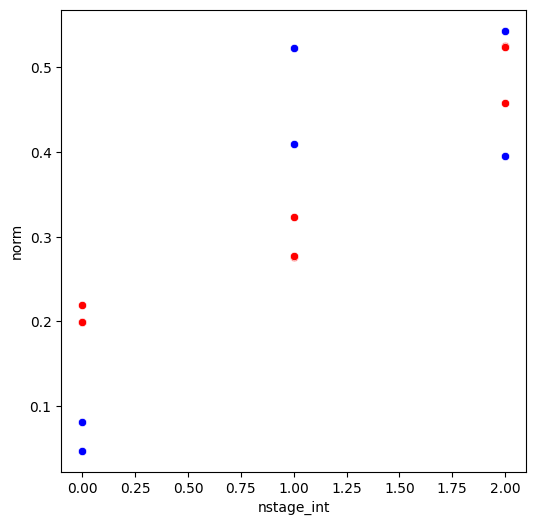

In [93]:
N0N1N2_AGGR = [
    'Kidney and Renal Pelvis',
    'Larynx',
    'Uterus',
]
N0N1N2_GENTLE = [
    'Colorectal',
    'Gallbladder',
    'Small Intestine',
]

maintable['nstage_int'] = maintable['derived_feature'].map({'N0': 0, 'N1': 1, 'N2': 2})
maintable['nstage_int'] = maintable['nstage_int'].apply(int)
maintable['norm'] = maintable['norm'].apply(float)
aggr_table = maintable[maintable['derived_group'].isin(N0N1N2_AGGR)]
gent_table = maintable[maintable['derived_group'].isin(N0N1N2_GENTLE)]
combined = maintable[maintable['derived_group'].isin(N0N1N2_AGGR + N0N1N2_GENTLE)]

fix, ax = plt.subplots(figsize=(6, 6))
sns.regplot(data=combined, x='nstage_int', y='norm', color='b', order=2) 
plt.show()

fix, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=aggr_table, x='nstage_int', y='norm', color='b') 
sns.scatterplot(data=gent_table, x='nstage_int', y='norm', color='r') 
plt.show()




**N0,N1,N2,N3 tissues**

In [95]:
# subset cancer types
temp = nstage_df[nstage_df['cancer_group'].isin(CGROUPS_NSTAGES_N0N1N2N3)]

# calculate prevalence per group
maintable = calculate_bm_prevalence_grouped(
    groups=GROUPS, 
    features=FEATURES, 
    response_field=NORM,
    min_records=MIN_RECORDS,
    s=s,
    df=temp
)
# normalise prevalence 
maintable = normalize_field_pergroup(
    groups=s.COMPOUND_GROUP,
    target_field=s.RATE_FIELD, 
    norm_field=s.NORM_FIELD,
    norm_meth=s.NORM_METH,
    df=maintable,
)

['Anus, Anal Canal and Anorectum', 'Breast', 'Esophagus', 'Lung and Bronchus', 'Mesothelioma', 'Nose, Nasal Cavity and Middle Ear', 'Oral', 'Skin', 'Stomach', 'Testis', 'Throat', 'Urinary Bladder', 'Vulva']


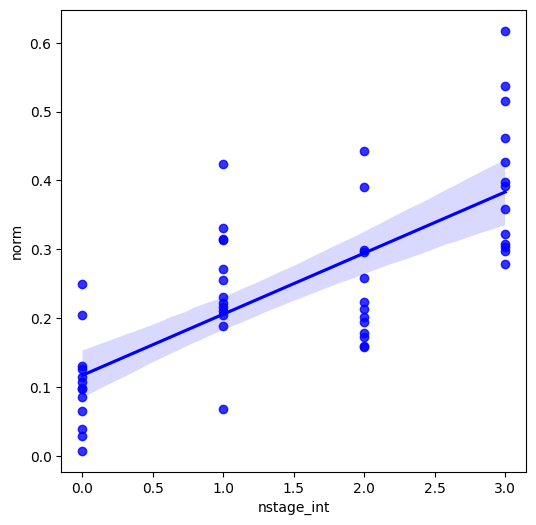

In [99]:
maintable['nstage_int'] = maintable['derived_feature'].map({'N0': 0, 'N1': 1, 'N2': 2, 'N3': 3})
maintable['nstage_int'] = maintable['nstage_int'].apply(int)
maintable['norm'] = maintable['norm'].apply(float)
maintable = maintable[~maintable['derived_group'].isin(['Penis','Ureter', 'Larynx'])]

print(sorted(maintable['derived_group'].unique()))

fix, ax = plt.subplots(figsize=(6, 6))
sns.regplot(data=maintable, x='nstage_int', y='norm', color='b', order=1) 
plt.show()


<br>
<br>
<br>
<br>
<br>
<br>
<br>